create a FHMM model which works with features from the Cept domain, will need to combine mapping the params back then combine into larger factorial hmm, then map this hmm back to cept domain

In [1]:
import sys

sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/classifiers/fhmm/fhmm_development', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
from importlib import reload
import audio_datastore.audio_datastore as myads

reload(myads)
import numpy as np
import matplotlib.pyplot as plt
from spafe.features import mfcc
from importlib import reload
import hmmlearn.hmm as hmm
import utils

reload(utils)
from spafe.utils import vis
from matplotlib.pyplot import figure

figure(figsize=(4, 4), dpi=60)
from scipy import signal
from scipy.stats import multivariate_normal as mvn

<Figure size 240x240 with 0 Axes>

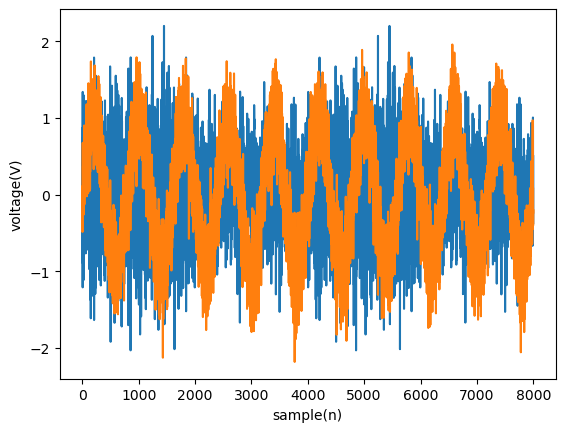

In [3]:

Fs = 8000
f1 = 20  # hz
f2 = 2000
sample = 8000
x = np.arange(sample)

n1 = np.random.normal(0, np.sqrt(0.1), sample)
n3 = np.random.normal(0, np.sqrt(0.58), sample)

# lpf
sos = signal.butter(10, 1500, 'lp', fs=Fs, output='sos')
n3_lpf = signal.sosfilt(sos, n3)

# hpf
sos = signal.butter(10, 1500, 'hp', fs=Fs, output='sos')
n3_hpf = signal.sosfilt(sos, n3)

# combine
noise_combined = np.append(n3_hpf[0:2000], n3_lpf[0:2000])
noise_combined = np.append(noise_combined, noise_combined)

s1 = np.sin(np.pi * f1 * x / Fs) + n1

s2 = noise_combined
plt.plot(x, s2)
plt.plot(x, s1)
# plt.plot(x, noise)
plt.xlabel('sample(n)')
plt.ylabel('voltage(V)')
plt.show()


0.29056839250381555


2.863067388432748

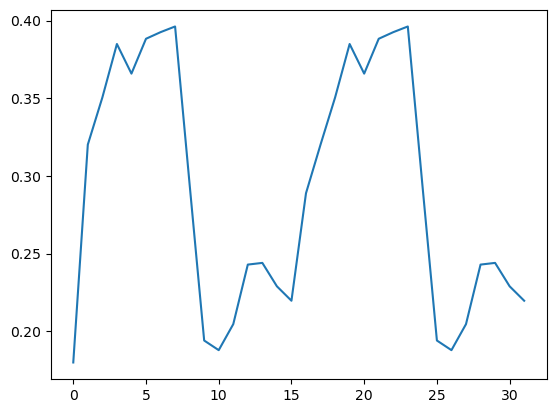

In [4]:
# snr before normalisation
ap = utils.periodic_power(s2, 500, 250)
plt.plot(ap)
print(np.mean(ap))
s1_ap = 0.58
s2_ap = 0.30
snr = 10 * np.log10(s1_ap / s2_ap)
snr


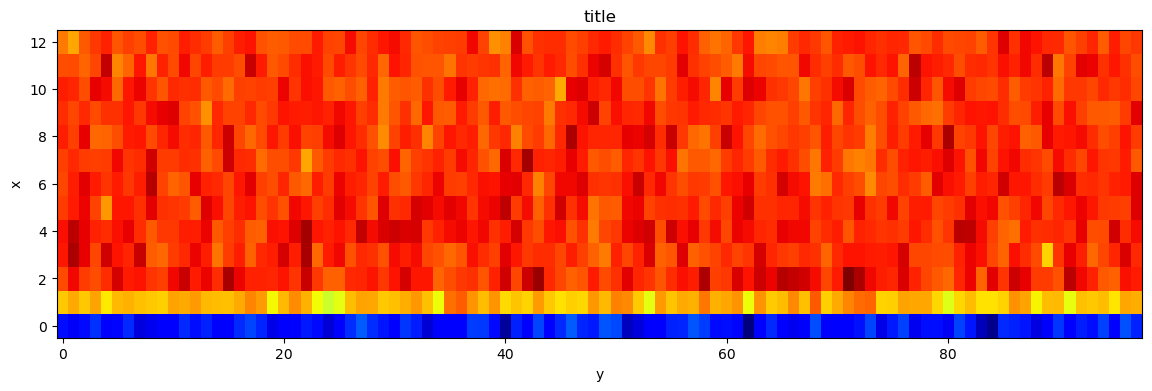

In [6]:
# import spafe.features.mfcc as mfcc

s1_feat = mfcc.mfcc(sig=s1, fs=8000, nfilts=40)
s1_hmm = hmm.GaussianHMM(2)
s1_hmm.fit(s1_feat)
# s1_hmm_sampled, _ = s1_hmm.sample(100)
vis.show_features(s1_feat, 'title', 'x', 'y')

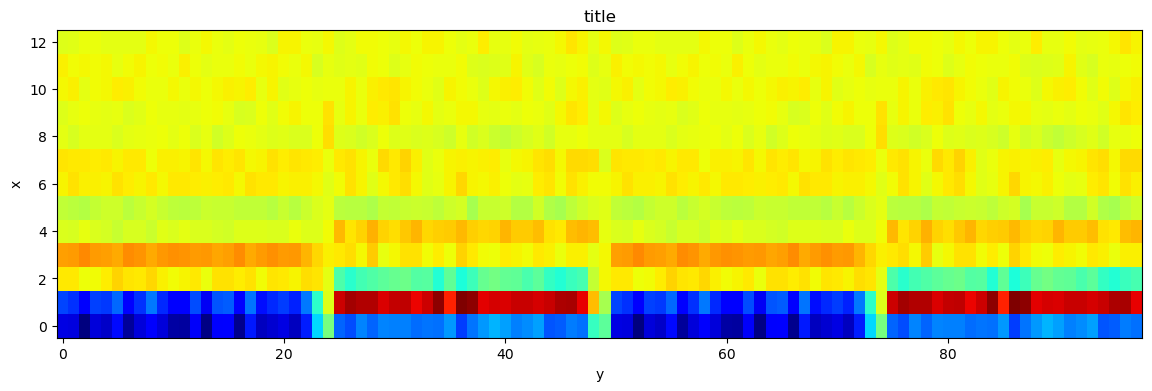

In [7]:
s2_feat = mfcc.mfcc(sig=s2, fs=8000, nfilts=40)
s2_hmm = hmm.GaussianHMM(2)
s2_hmm.fit(s2_feat)
# _, ss = s2_hmm.decode(s2_feat)
# s2_hmm_sampled, _ = s2_hmm.sample(100)
vis.show_features(s2_feat, 'title', 'x', 'y')
# plt.plot(ss)

In [8]:
import helper_functions as hf
reload(hf)

hmm_combined, state_dict = hf.adapt_speaker_model(s1_hmm, s2_hmm, 1)

<Figure size 240x240 with 0 Axes>

<Figure size 240x240 with 0 Axes>

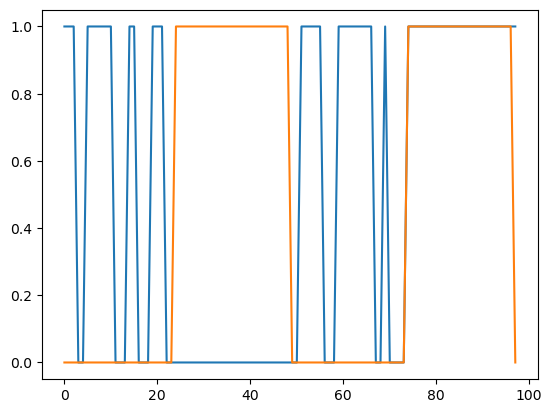

In [11]:
s3 = s1 + s2
s3_feat = mfcc.mfcc(sig=s3, fs=8000, nfilts=40)
ll, ss = hmm_combined.decode(s3_feat)

ss01 = []
ss02 = []
for x in range(len(ss)):
    temp = state_dict[ss[x]]
    ss01.append(temp[0])
    ss02.append(temp[1])

plt.plot(ss01)
plt.plot(ss02)

In [12]:
s1_hmm.score(s3_feat)

-5220.523902417315